***Case: Classificação de clientes para Churn***

# Settings

## Libraries

In [ ]:
!pip install lime

In [ ]:
# Data Wrangling

import pandas as pd
import numpy as np

# Data visualization

from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning 

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, scale, LabelEncoder
from sklearn import metrics as mtc

# Model interpretation
from lime.lime_tabular import LimeTabularExplainer

## Set theme

In [ ]:
scatter_kwargs = dict(palette='viridis', alpha=0.8, linewidth=0)

## Functions

In [ ]:
# Usada para exibir as categorias das variáveis categóricas num DataFrame

def categorical_unique(df, max_values):
  # inicializando uma cópia do DataFrame informado e criando uma lista com o
  # nome das variáveis categoricas
  df = df.copy()
  cat_features = df.select_dtypes(exclude='number').columns

  # iterando sobre cada coluna categórica, utilizando 'cat_features'
  for column in cat_features:
    
    # para cada coluna, pritamos seu nome com o parâmetro end='', para que
    # os próximos prints fiquem na mesma linha no output.
    # inicializamos 'value_count' com 0, a variável servirá para limitar colunas
    # com muitos valores únicos 

    print(f'{column}: ', end='')
    value_count = 0

    for value in df[column].unique():

      # acessamos os valores unicos de cada coluna com .unique()

      value_count += 1

      if value_count > max_values:
        # caso value_count for maior que o parametro max_values
        # a iteração para.

        print('...')
        break

      elif value == df[column].unique()[-1]:

          # se o valor for o último valor único da coluna
          # printamos o valor com um '.'

          print(f'{value}.')
          break

      else:

          # senão printamos o valor com ','

          print(f'{value}, ', end='')


# Usada para plotar a frequência das categorias para cada variável categórica 

def categorical_freq_plot(df):
    
    # importando pyplot para os gráficos
    from matplotlib import pyplot as plt

    # inicializando uma cópia do DataFrame e uma lista com os nomes
    # das variáveis categoricas

    df = df.copy()
    cat_features = df.select_dtypes(exclude='number').columns

    # iterando sobre cada coluna na lista

    for column in cat_features:

      # criando uma tabela auxiliar para guardar as categorias
      # e suas contagens, para posterior plotagem

      aux = df[column].value_counts()
      plt.bar(aux.index, aux.values)
      plt.title(f'Distribuição dos valores de {column}')
      plt.xticks(rotation=45)
      plt.show()

# utilizada para codificar variáveis categorias ou escalonar numericas
# quando o codificador ou escalonador só não aceita uma Series/array 1d, por vez

def encoder_col(df, encoder):
  df = df.copy()
  for col in df.columns:
    df[col] = encoder().fit_transform(df[col])

  return df

def cross_avaliate(models: list, X, y, avaliator, score_type='roc_auc', sort_by=0):

    # importações necessárias
    from sklearn.model_selection import cross_val_score
    import pandas as pd

    # a função tem dois caminhos principais dependendo do parâmetro score_type
    # se para score_type for passado apenas uma string com a metrica, ou se for passado
    # uma lista de strings, contendo as métricas.

    # caso for uma lista de métricas:

    if type(score_type).__name__ == 'list':

      # primeiro inicializamos a coluna 'Models' do DataFrame
      # que será retornado ao usuário.
       
      dict_df = {'Models': []}

      # após, para cada metrica inicializamos uma coluna ao DataFrame
      for score in score_type:

        dict_df[score] = []
      
      # e para cada modelo na lista de modelos adicionamos seu nome
      # e calculamos as métricas 
      for model in models:

        dict_df['Models'].append(type(model).__name__)

        for score in score_type:
          scoring = cross_val_score(model, X, y, cv=avaliator, scoring=score)
          dict_df[score].append(scoring.mean())
      
      # por fim criamos o DataFrame e retornamos ao usuário
      df = pd.DataFrame(dict_df)

      return df.sort_values(by=score_type[sort_by], ascending=False).reset_index(drop=True)

    # caso for apenas uma string com a metrica desejada
    else:
      
      # inicializando as listas necessárias para o DataFrame
      scores = []
      models_for_frame = []
 
      # calculando métricas para cada modelo
      for model in models:

        scoring = cross_val_score(model, X, y, cv=avaliator, scoring=score_type)
        scores.append(scoring.mean())
        models_for_frame.append(type(model).__name__)
       
      # e por fim criando e retornando o DataFrame
      df = pd.DataFrame({
          'Models': models_for_frame,
          f'{score_type}': scores
      })

      return df.sort_values(by='Avaliation', ascending=False).reset_index(drop=True)

# utilizada para automatizar a visualização das métricas de seus modelos em um tipo de Cross-validation desejado
def param_search(models: list, list_param_grids: list, searcher, X, y, scoring='roc_auc', n_iter=10, n_jobs=-1):

    # importações
    import pandas as pd
    
    # inicializando listas posterior criação de um DataFrame
    best_estimators = []
    scores = []
    adjusted_params = []

    # iterando sobre cada modelo e os parametros passados para cada um deles
    # realizando a busca e guardando o nome do modelo no qual foi aplicado a busca
    # seus parâmetros padrão e os ajustados pela busca.
    for model, param_grid in zip(models, list_param_grids):
        search = searcher(model, param_grid, n_iter=n_iter, n_jobs=n_jobs, scoring=scoring).fit(X, y)

        best_params = search.best_estimator_.get_params()
        default_params = model.get_params()
        
        # a coluna Adjusted Parameters é criada com este dict comprehension, que adiciona uma chave e um valor
        # se o valor do parâmetro for diferente do padrão que ja vem no modelo.
        adjusted_params.append({k: v for k, v in best_params.items() if v != default_params[k]})

        best_estimators.append(type(search.best_estimator_).__name__)
        scores.append(search.best_score_)
    
    # por fim criando e retornando o DataFrame
    df = pd.DataFrame({
        'Models': best_estimators,
        'Avaliation': scores,
        'Adjusted Parameters': adjusted_params
    })

    pd.set_option('display.max_colwidth', 200)

    return df.sort_values(by='Avaliation', ascending=False).reset_index(drop=True)

## Load Data

In [ ]:
df = pd.read_excel('https://docs.google.com/spreadsheets/d/1UejtcM-xnqGswl66O4O630MKDJtvRXQp/export?usp=xlsx')

# Data Understanding

**Nesta etapa temos o primeiro contato com os dados, analisamos sua estrutura, como estão distribuidos e suas principais características**

**Começamos por entender como os dados estão dispostos, quais suas features e os valores possiveis para as fatures categoricas e suas frequências no dataset**

In [ ]:
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


Podemos ver colunas binarias no dataset, que poderiam estar codificadas com 0 e 1, porém estão como 'No', 'Yes'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


Nenhum nulo foi identificado até o momento.

As variáveis estão com seus tipos de dados
correspondentes.

Um total de 21 variáveis e 7032 observações.

In [ ]:
categorical_unique(df, 4)

customerID: 7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOCW, ...
gender: Female, Male.
Partner: Yes, No.
Dependents: No, Yes.
PhoneService: No, Yes.
MultipleLines: No phone service, No, Yes.
InternetService: DSL, Fiber optic, No.
OnlineSecurity: No, Yes, No internet service.
OnlineBackup: Yes, No, No internet service.
DeviceProtection: No, Yes, No internet service.
TechSupport: No, Yes, No internet service.
StreamingTV: No, Yes, No internet service.
StreamingMovies: No, Yes, No internet service.
Contract: Month-to-month, One year, Two year.
PaperlessBilling: Yes, No.
PaymentMethod: Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic).
Churn: No, Yes.


As features categóricas com exceção de customerID não passam de 4 categorias únicas, o que facilita a análise e modelagem.

Sem presença de outliers.

In [ ]:
# Verificando quantidade das categorias
for column in df.columns:
  print(df[column].value_counts())

customerID
7590-VHVEG    1
0265-PSUAE    1
2956-GGUCQ    1
6008-NAIXK    1
5956-YHHRX    1
             ..
7874-ECPQJ    1
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
3186-AJIEK    1
Name: count, Length: 7032, dtype: int64
gender
Male      3549
Female    3483
Name: count, dtype: int64
SeniorCitizen
0    5890
1    1142
Name: count, dtype: int64
Partner
No     3639
Yes    3393
Name: count, dtype: int64
Dependents
No     4933
Yes    2099
Name: count, dtype: int64
tenure
1     613
72    362
2     238
3     200
4     176
     ... 
38     59
28     57
39     56
44     51
36     50
Name: count, Length: 72, dtype: int64
PhoneService
Yes    6352
No      680
Name: count, dtype: int64
MultipleLines
No                  3385
Yes                 2967
No phone service     680
Name: count, dtype: int64
InternetService
Fiber optic    3096
DSL            2416
No             1520
Name: count, dtype: int64
OnlineSecurity
No                     3497
Yes                    2015
No internet service    15

In [ ]:
df[df.duplicated()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


Nenhuma Linha duplicada.

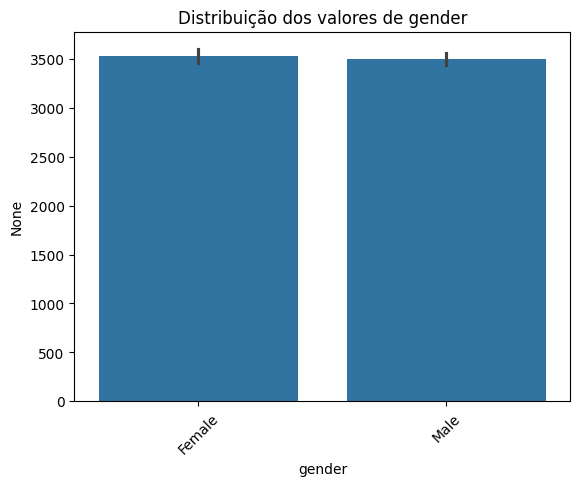

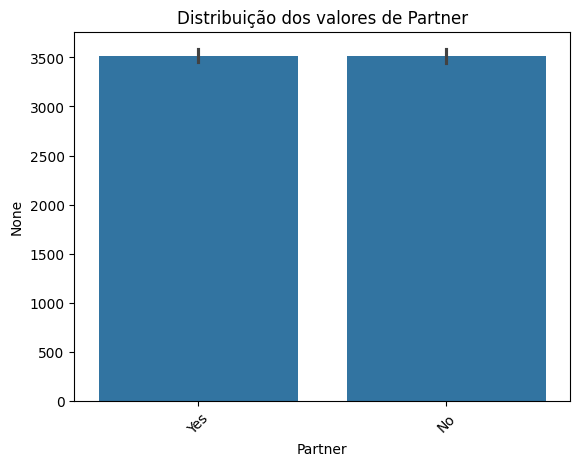

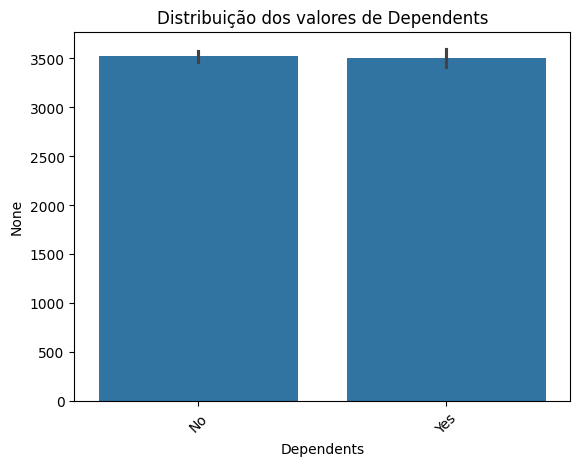

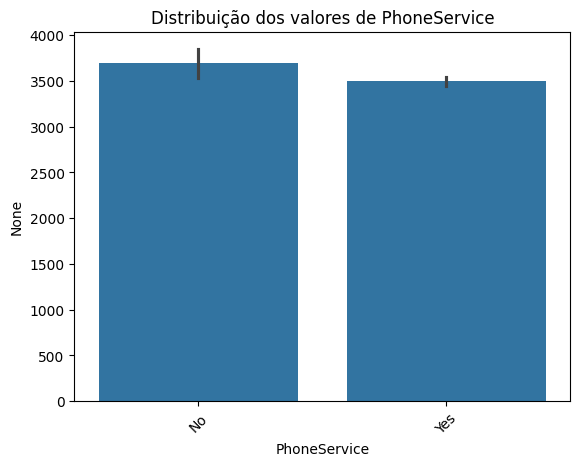

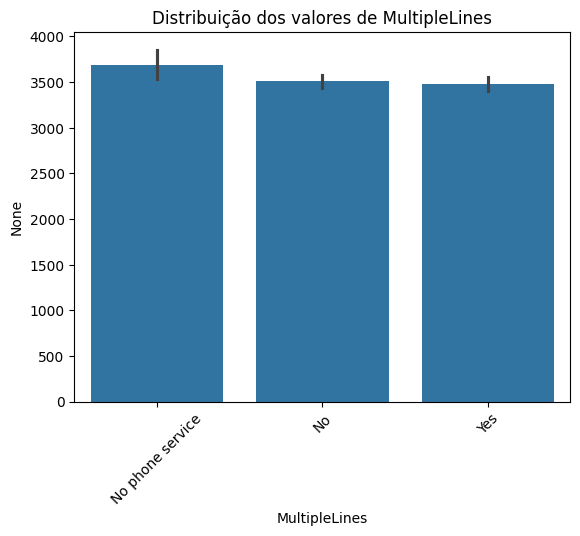

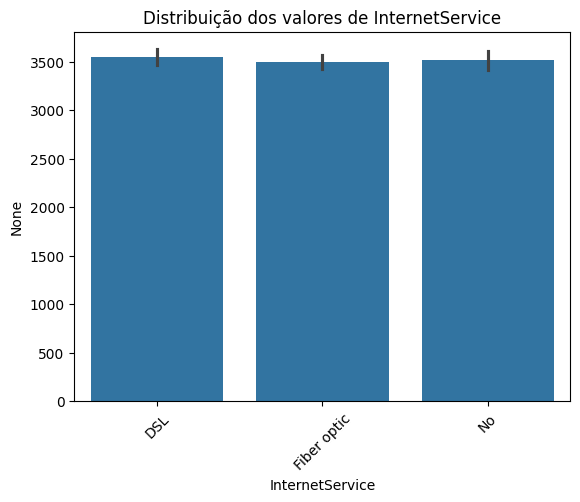

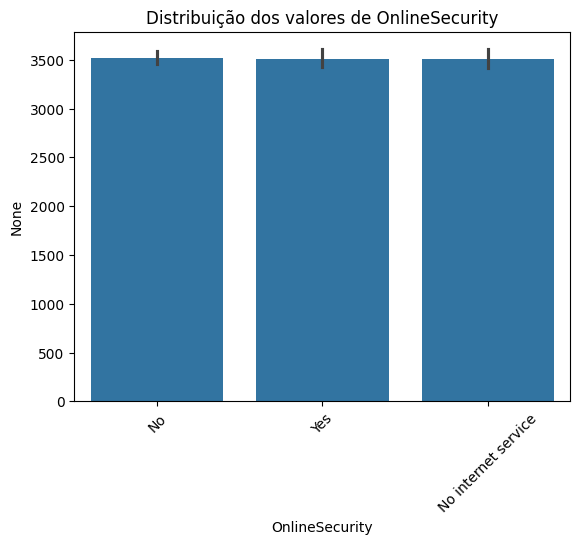

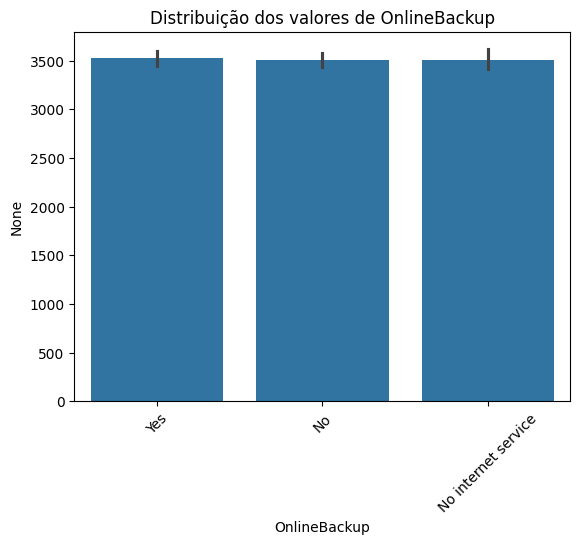

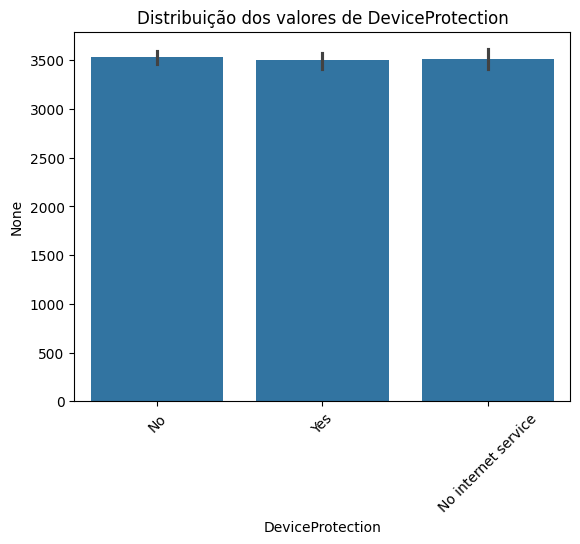

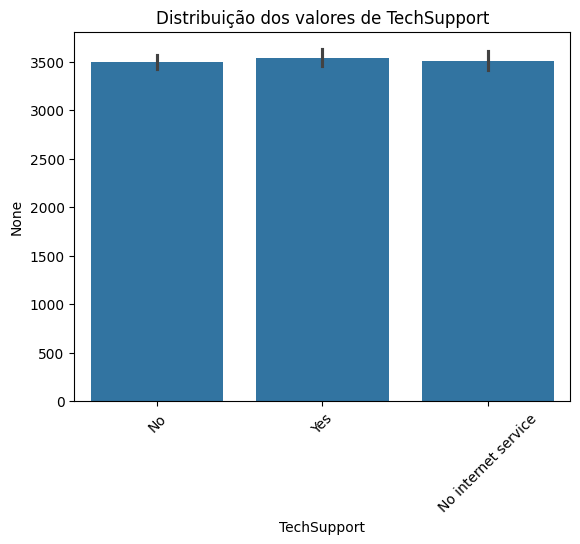

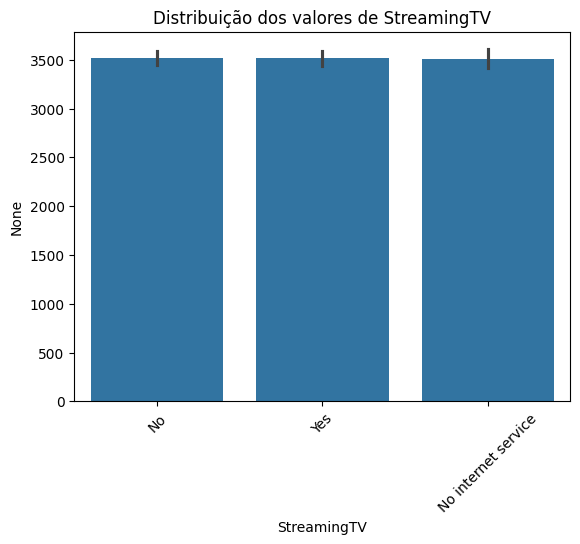

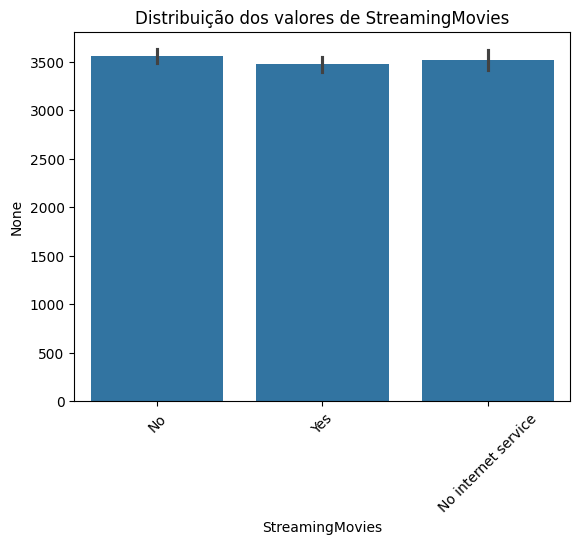

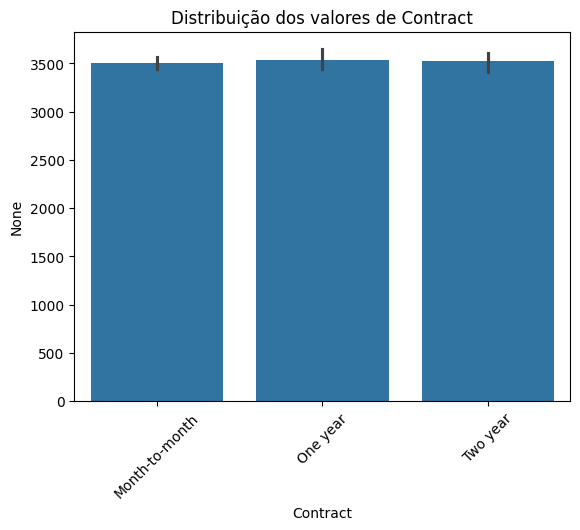

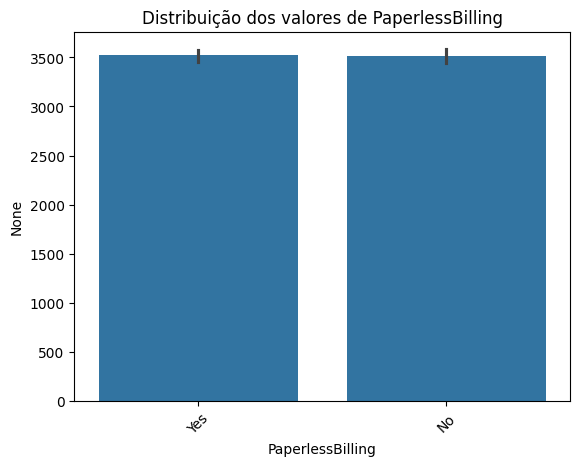

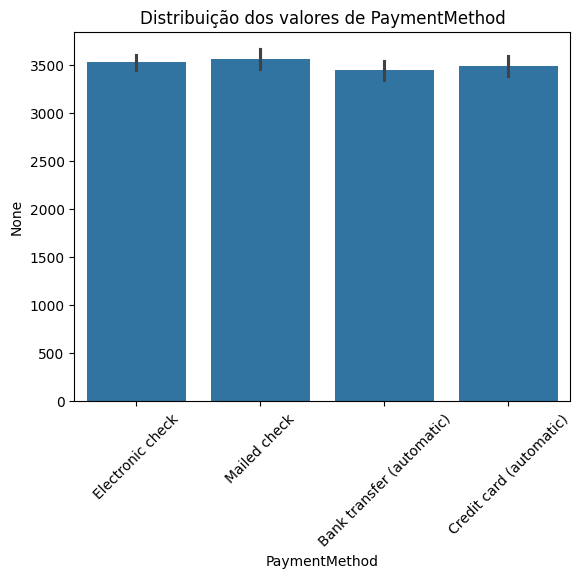

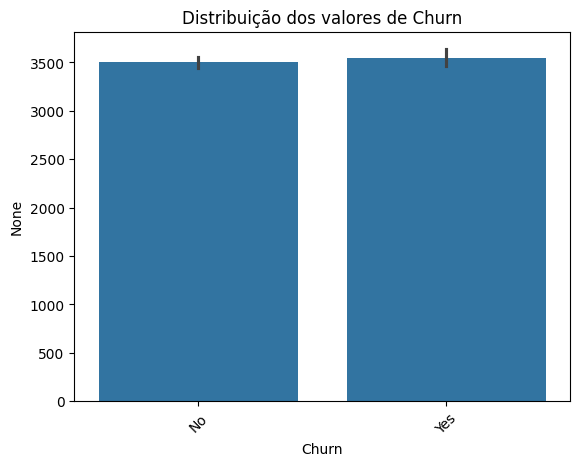

In [ ]:
categorical_freq_plot(df.drop('customerID', axis=1))

**Depois partimos para o entendimento das features numéricas, com suas estatístcias descritivas, distribuições e limites.**

In [ ]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


Como TotalCharges há uma escala de valores maior que as demais, se faz necessário escalonamento.

O desvio padrão de TotalCharges é maior que a média, mas sendo explicado pela visão de negócio sobre a coluna, ja que clientes com variados tipos de serviços e tempo de contratação tem valores diferentes de TotalCharges.

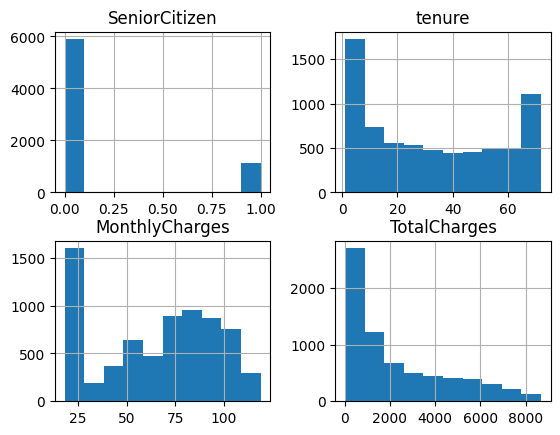

In [ ]:
df.select_dtypes('number').hist();

Tenure (tempo de contrato em meses) tem uma quantidade razoável de clientes com maior tempo de contratação. o que explica valores grandes em TotalCharges.

MonthlyCharges tem uma alta quantidade de clientes com pagamento mensal de até R$ 25, indicando um plano de assinatura mais comum e barato.

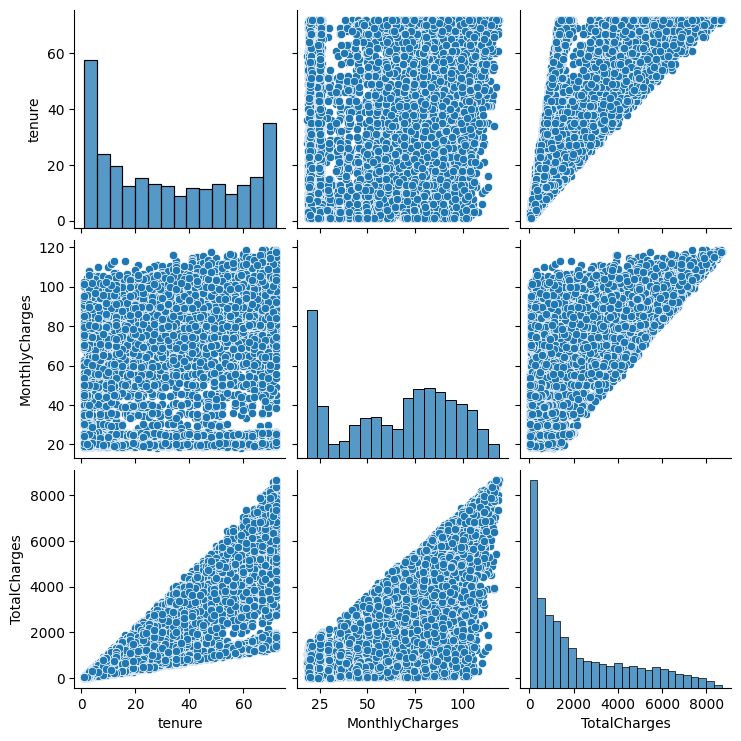

In [ ]:
sns.pairplot(df.drop(columns=['SeniorCitizen']));

Capturamos uma erlação linear positiva entre Tenure e TotalCharges, o que já era esperado.

<Axes: >

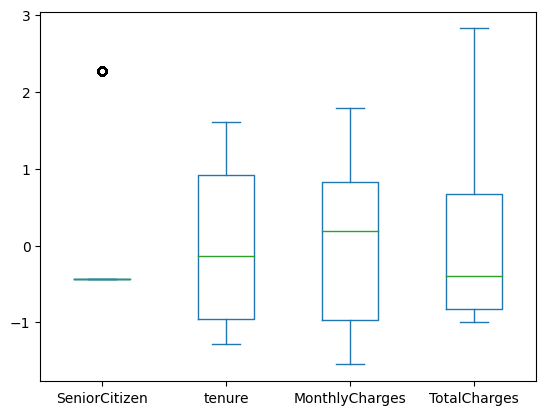

In [ ]:
df.select_dtypes('number').apply(scale).plot.box()

<Axes: >

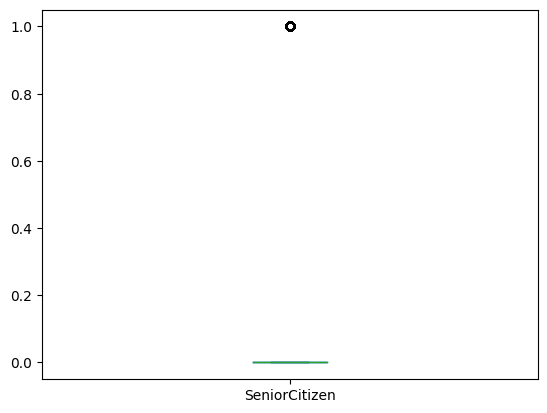

In [ ]:
df['SeniorCitizen'].plot.box()

Analisando com boxplots não vemos a presença de outliers em nenhuma variável.

**analisando correlações lineares entre as Features**

<Axes: >

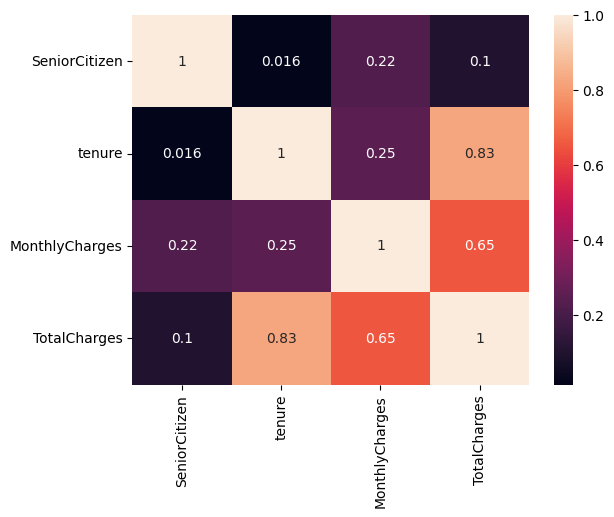

In [ ]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

## **Feature Importance**

In [ ]:
skf = StratifiedKFold(shuffle=True, random_state=42)

In [ ]:
df_test = df.drop('customerID', axis=1)

cat_cols = df_test.select_dtypes(exclude='number').columns

feature_prep = df_test.copy()

feature_prep[cat_cols] = encoder_col(feature_prep[cat_cols], LabelEncoder)

feature_prep[['tenure', 'MonthlyCharges', 'TotalCharges']] = StandardScaler().fit_transform(feature_prep[['tenure', 'MonthlyCharges', 'TotalCharges']])

In [ ]:
X = feature_prep.drop(columns=['Churn'])
y = feature_prep['Churn']


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
cross_avaliate([model], X, y, skf, ['roc_auc', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])

,Models,roc_auc,accuracy,balanced_accuracy,precision,recall,f1
0,DecisionTreeClassifier,0.656037,0.7244,0.65533,0.488992,0.502948,0.487862


In [ ]:
features_list = feature_prep.columns
importances = model.feature_importances_

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_list, importances)]

feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

for tupl in feature_importances:
    print(f'feature: {tupl[0]:20} importance: {tupl[1]}')

feature: TotalCharges         importance: 0.22
feature: MonthlyCharges       importance: 0.2
feature: Contract             importance: 0.17
feature: tenure               importance: 0.12
feature: OnlineSecurity       importance: 0.05
feature: PaymentMethod        importance: 0.04
feature: gender               importance: 0.03
feature: SeniorCitizen        importance: 0.02
feature: Partner              importance: 0.02
feature: MultipleLines        importance: 0.02
feature: InternetService      importance: 0.02
feature: TechSupport          importance: 0.02
feature: PaperlessBilling     importance: 0.02
feature: Dependents           importance: 0.01
feature: OnlineBackup         importance: 0.01
feature: DeviceProtection     importance: 0.01
feature: StreamingTV          importance: 0.01
feature: StreamingMovies      importance: 0.01
feature: PhoneService         importance: 0.0


In [ ]:
columns2drop = [tupl[0] for tupl in feature_importances if tupl[1] < 0.02]

In [ ]:
feature_prep.drop(columns=columns2drop, inplace=True)

X = feature_prep.drop(columns=['Churn'])
y = feature_prep['Churn']


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
cross_avaliate([model], X, y, skf, ['roc_auc', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])

,Models,roc_auc,accuracy,balanced_accuracy,precision,recall,f1
0,DecisionTreeClassifier,0.652768,0.719282,0.646029,0.479505,0.48847,0.484567


In [ ]:
features_list = feature_prep.columns
importances = model.feature_importances_

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_list, importances)]

feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

for tupl in feature_importances:
    print(f'feature: {tupl[0]:20} importance: {tupl[1]}')

feature: MonthlyCharges       importance: 0.24
feature: TotalCharges         importance: 0.24
feature: Contract             importance: 0.17
feature: tenure               importance: 0.11
feature: OnlineSecurity       importance: 0.05
feature: PaymentMethod        importance: 0.04
feature: PaperlessBilling     importance: 0.03
feature: gender               importance: 0.02
feature: SeniorCitizen        importance: 0.02
feature: Partner              importance: 0.02
feature: MultipleLines        importance: 0.02
feature: InternetService      importance: 0.02
feature: TechSupport          importance: 0.02


# Data Preparation

**Nessa etapa, realizamos as alterações e os tratamentos necessários para o modelo**

**Preparando os dados**

In [ ]:
df.drop('customerID', axis=1, inplace=True)

In [ ]:
df.drop(columns=columns2drop, inplace=True)

cat_cols = df.select_dtypes(exclude='number').columns

feature_prep = df.copy()

feature_prep[cat_cols] = encoder_col(feature_prep[cat_cols], LabelEncoder)

feature_prep[['tenure', 'MonthlyCharges', 'TotalCharges']] = StandardScaler().fit_transform(feature_prep[['tenure', 'MonthlyCharges', 'TotalCharges']])

**Dividindo massas para modelagem**

In [ ]:
X = feature_prep.drop(columns=['Churn'])
y = feature_prep['Churn']


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Modelling

## Criando e treinando modelos

**Decision Tree Classifier**

In [ ]:
DT_class = DecisionTreeClassifier()
DT_class.fit(x_train, y_train)

DecisionTreeClassifier()

**Random Forest Classifier**

In [ ]:
RF_class = RandomForestClassifier()
RF_class.fit(x_train, y_train)

RandomForestClassifier()

**Gradient Boosting Classifier**

In [ ]:
GB_class = GradientBoostingClassifier()
GB_class.fit(x_train, y_train)

GradientBoostingClassifier()

**K-Nearest Neighbors**

In [ ]:
KNN = KNeighborsClassifier()
KNN.fit(x_train, y_train)

KNeighborsClassifier()

**SVM**

In [ ]:
SVM = SVC()

**Neural Network - MLP**

In [ ]:
neural = MLPClassifier(max_iter=500, hidden_layer_sizes=(100, 50, 20))
neural.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50, 20), max_iter=500)

## Avaliando modelos

In [ ]:
cross_avaliate([DT_class, RF_class, GB_class, KNN, SVM, neural], X, y, skf, ['roc_auc', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])

,Models,roc_auc,accuracy,balanced_accuracy,precision,recall,f1
0,GradientBoostingClassifier,0.844466,0.801194,0.711515,0.660268,0.521135,0.580913
1,RandomForestClassifier,0.819391,0.789675,0.692141,0.640341,0.491696,0.554700
2,SVC,0.796402,0.799488,0.690037,0.684175,0.456383,0.547489
3,MLPClassifier,0.780117,0.750572,0.675061,0.530886,0.510903,0.506634
4,KNeighborsClassifier,0.774144,0.767775,0.677825,0.574841,0.485805,0.526527
5,DecisionTreeClassifier,0.649421,0.721556,0.649365,0.477699,0.483656,0.485556


## Otimização de HiperParâmetros

**Foram Escolhidos os 3 melhores na avaliação de Cross-Validation para a otimização**

In [ ]:
param_search([GB_class, RF_class, SVM], [
    {
        'max_depth': [3, 5, 7, 9],
        'min_samples_split': [2, 3, 4, 5],
        'min_samples_leaf': [1, 2, 3, 4],
        'max_features': ['sqrt', 'log2', 0.2, 0.3],
        'learning_rate': [0.1, 0.2, 0.3, 0.4],
        'n_estimators': [100, 150, 200, 250],
        'subsample': [0.5, 0.7, 0.8, 1.0]
    },

    {
        'max_depth': [3, 5, 7, 9],
        'min_samples_split': [2, 3, 4, 5],
        'min_samples_leaf': [1, 2, 3, 4],
        'max_features': ['sqrt', 'log2', 0.2, 0.3],
        'bootstrap': [False, True],
        'n_estimators': [100, 150, 200, 250],
    },

    {
        'C': [0.5, 1.0, 2, 5, 9],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
], RandomizedSearchCV, X, y)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,Models,Avaliation,Adjusted Parameters
0,RandomForestClassifier,0.845035,"{'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 250}"
1,GradientBoostingClassifier,0.842220,"{'learning_rate': 0.2, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 150}"
2,SVC,0.825790,"{'C': 0.5, 'kernel': 'linear'}"


**tunnando e avaliando modelos**

In [ ]:
RF_class_tunned = RandomForestClassifier(
    max_depth=7, max_features='log2',
    min_samples_leaf=2, min_samples_split=4,
    n_estimators=250
)

GB_class_tunned = GradientBoostingClassifier(
    learning_rate=0.2,
    max_features='log2',
    min_samples_split=5,
    n_estimators=150
)

SVM_tunned = SVC(C=0.5, kernel='linear')

In [ ]:
cross_avaliate([RF_class_tunned, GB_class_tunned, SVM_tunned], X, y, skf, ['roc_auc', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])


,Models,roc_auc,accuracy,balanced_accuracy,precision,recall,f1
0,RandomForestClassifier,0.846039,0.804323,0.707395,0.681768,0.502387,0.574485
1,GradientBoostingClassifier,0.842803,0.797355,0.712626,0.654670,0.533436,0.579799
2,SVC,0.826294,0.795647,0.705000,0.646240,0.511489,0.570985


# Interpretabilidade de modelo

**O modelo mais performático na avaliação cruzada, terá sua tomada de decisão explicitada pelo algoritimo LIME**

In [ ]:
random_idx = np.random.randint(0, len(x_train))

lime_tabular = LimeTabularExplainer(x_train.to_numpy(), training_labels=y_train, feature_names=X.columns, class_names=['No', 'Yes'])
explainer = lime_tabular.explain_instance(x_train.to_numpy()[random_idx], GB_class.predict_proba)
explainer.show_in_notebook()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
